<a href="https://colab.research.google.com/github/momcilol/Butterflies/blob/main/Butterfly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leptirica
U ovom projektu napravljena je neuronska mreza koja treba da izvrsi klasifikaciju 75 vrsta leptira. Ulazne slike su formata 224x224x3.  
Postoje tri skupa podataka:
- Trening skup: 9285 slika
- Test skup: 375 slika
- Validacioni skup: 375 slika  

Sve vrste imaju jednaki broj slika u Test i Validacionom skupu, dok kod Trening skupa taj broj se krece od 102 do 187 slika po leptiru.

# Priprema

## Povezivanje sa Google Drive-om  
Tamo se nalazi kaggle.json file, koji sadrži username i password mog Kaggle naloga, koji mi treba za skidanje skupa podataka sa Kaggle sajta.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instaliranje kaggle-a i dobavljanje skupa podataka


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d gpiosenka/butterfly-images40-species

In [ ]:
! mkdir /content/butterfly

In [ ]:
! unzip /content/butterfly-images40-species.zip -d /content/butterfly/

# Importi  
Importovanje nepohodnih biblioteke za rad

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os
import itertools
import random

from PIL import Image

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Input, Layer, BatchNormalization, Rescaling, Concatenate, RepeatVector, Multiply

## Spremanje podataka  
Ucitavamo slike i njihove labele, i spremamo ih za analizu.

Najpre ucitavamo meta podatke

In [ ]:
class_dict = pd.read_csv('/content/butterfly/class_dict.csv', usecols=["class", "SCIENTIFIC NAME"])
butter_files = pd.read_csv('/content/butterfly/butterflies.csv', usecols=['labels', 'filepaths'])

files = butter_files['filepaths'].values.tolist()
train_files = [f for f in files if f.startswith('train')]
test_files = [f for f in files if f.startswith('test')]
valid_files = [f for f in files if f.startswith('valid')]

train_num = len(train_files)
test_num = len(test_files)

labels = butter_files['labels'].values.tolist()
train_labels = labels[:train_num]
test_labels = labels[train_num:(train_num + test_num)]
valid_labels = labels[(train_num + test_num):]

classes = class_dict['class'].values.tolist()

In [ ]:
print(len(train_files))
print(len(train_labels))
print(len(test_files))
print(len(test_labels))
print(len(valid_files))
print(len(valid_labels))
print(classes)

9285
9285
375
375
375
375
['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA', 'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA', 'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK', 'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY', 'PAPER KITE', 'PEACOCK', 'PINE WHITE', 'PIPEVINE SWALLOW', 'POPINJAY', 'PURPLE HAIRSTREAK', 'PURPLISH COPPER', 'Q

### Trenazni skup podataka
Ovaj skup podataka cemo koristiti da treniramo nas model

In [ ]:
train_data = []
train_classes = []
class_num = len(classes)

path = os.path.join('/content/butterfly')

for i in range(train_num):
  try:
    image = Image.open(path + '/' + train_files[i])
    image = image.resize((224, 224))
    image = np.array(image)
    # print("image done")
    train_data.append(image)
    train_classes.append(classes.index(train_labels[i]))

  except:
    print("Error loading image")


train_data = np.array(train_data)
train_classes = np.array(train_classes)
  

In [ ]:
print(train_data.shape)
print(train_classes.shape)

(9285, 224, 224, 3)
(9285,)


### Validacioni skup podataka
Ovaj skup cemo koristiti kao validaciju pri treniranju naseg modela neuronske mreze

In [ ]:
valid_data = []
valid_classes = []
class_num = len(classes)

path = os.path.join('/content/butterfly')

for i in range(test_num):
  try:
    image = Image.open(path + '/' + valid_files[i])
    image = image.resize((224, 224))
    image = np.array(image)
    # print("image done")
    valid_data.append(image)
    valid_classes.append(classes.index(valid_labels[i]))

  except:
    print("Error loading image")


valid_data = np.array(valid_data)
valid_classes = np.array(valid_classes)

In [ ]:
print(valid_data.shape)
print(valid_classes.shape)

(375, 224, 224, 3)
(375,)


### Skup podataka za testiranje  
Ovaj skup podataka cemo koristiti u predikciji

In [ ]:
test_data = []
test_classes = []
class_num = len(classes)

path = os.path.join('/content/butterfly')

for i in range(test_num):
  try:
    image = Image.open(path + '/' + test_files[i])
    image = image.resize((224, 224))
    image = np.array(image)
    # print("image done")
    test_data.append(image)
    test_classes.append(classes.index(test_labels[i]))

  except:
    print("Error loading image")


test_data = np.array(test_data)
test_classes = np.array(test_classes)

In [ ]:
print(test_data.shape)
print(test_classes.shape)

(375, 224, 224, 3)
(375,)


### Uvecavanje podataka
Da bismo imali sto bolje rezultate treniranja, koristicemo tehniku koja se zove Data Augmentation, tj. primenjivacemo proizvoljne transformacije na slikama: rotaciju, obrtanje, zoomiranje, shiftovanje... 

In [ ]:
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
brightness_range=[0.2, 1.0],
vertical_flip=True,
horizontal_flip=True,
fill_mode='nearest')

#### Primer

Original

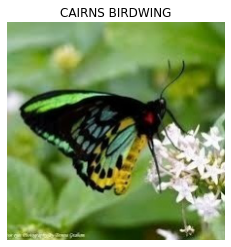

In [ ]:
index = random.randrange(train_num)
rnd_img = train_data[index]
plt.imshow(rnd_img)
plt.title(labels[index])
plt.axis('off')
plt.show()

In [ ]:
rnd_img = rnd_img.reshape((1,) + rnd_img.shape)

Dobijeni

In [ ]:
i = 0
for batch in datagen.flow(rnd_img, batch_size=5):
  plt.figure(i)
  plt.imshow(image.array_to_img(batch[0]))
  plt.title(labels[index])
  i += 1
  if i > 4:
    break
  
plt.show()

# Pravljenje model  
Najpre cemo napraviti model nase neuronske mreze

## Osnova modela  
Kako su slika velika i zahtevne za treniranje modela, a operacije i detekcije koje se izvrsavaju u konvolucionom delu neuronske mreze slicne za sve mreze, koristicemo Keras-ov istrenirani model EfficientNetB0 kao osnovu (s obzirom da B0 ocekuje 224x224 ulaznu dimenziju), dok cemo posle samo istrenirati zavrsni sloj nase mreze.

In [ ]:
shape = train_data[1].shape

In [ ]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=shape,
    include_top=False,
    pooling='avg'
)
pretrained_model.trainable = False

## Zavrsni sloj i spajanje
Zavrsni sloj se sastoji od potpuno povezanih slojeva. Njega nastavljamo na EfficientNet osnovu i dobijamo nas trazeni model. Koristimo kerasov FunctionalAPI za pravljenje naseg modela.

In [ ]:
inputs = pretrained_model.input

x = Dense(640, activation='relu')(pretrained_model.output)
x = Dense(160, activation='relu')(x)

outputs = Dense(class_num, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
plot_model(model)

Kao sto vidimo model je jako velik (18M trenaznih parametara), cak i sa vec istreniranim modelom, sto znaci da ce nam trbati dosta vremena da ga istreniramo.

# Treniranje modela

Najpre cemo prebaciti klase u kategoricne izlaze. Dakle, od 4 dobijamo niz u kojem su svi elementi 0, sem elementa na idneksu 4 koji je jedan. Niz je duzine koju mi zadamo, ili one duzine, koje je najveci element u tom nizu brojeva. Primer:


In [ ]:
to_categorical([4], 13)

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [ ]:
train_classes_one_hot = to_categorical(train_classes, class_num)
print(train_classes_one_hot)
print(train_classes_one_hot.shape)

In [ ]:
valid_classes_one_hot = to_categorical(valid_classes, class_num)
print(valid_classes_one_hot)
print(valid_classes_one_hot.shape)

In [ ]:
train_it = datagen.flow(x=train_data, y=train_classes_one_hot)
valid_it = datagen.flow(x=valid_data, y=valid_classes_one_hot)

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(train_it, epochs=10, steps_per_epoch=291, validation_data=valid_it)

Epoch 1/10
291/291 [==============================] - 689s 2s/step - loss: 1.2214 - accuracy: 0.6732 - val_loss: 0.6213 - val_accuracy: 0.8187
Epoch 2/10
291/291 [==============================] - 663s 2s/step - loss: 0.6303 - accuracy: 0.8124 - val_loss: 0.5354 - val_accuracy: 0.8507
Epoch 3/10
291/291 [==============================] - 666s 2s/step - loss: 0.4997 - accuracy: 0.8527 - val_loss: 0.3888 - val_accuracy: 0.8667
Epoch 4/10
291/291 [==============================] - 632s 2s/step - loss: 0.4338 - accuracy: 0.8679 - val_loss: 0.3587 - val_accuracy: 0.8800
Epoch 5/10
291/291 [==============================] - 631s 2s/step - loss: 0.4088 - accuracy: 0.8760 - val_loss: 0.4195 - val_accuracy: 0.8853
Epoch 6/10
291/291 [==============================] - 635s 2s/step - loss: 0.3590 - accuracy: 0.8873 - val_loss: 0.3588 - val_accuracy: 0.9040
Epoch 7/10
291/291 [==============================] - 628s 2s/step - loss: 0.3284 - accuracy: 0.8953 - val_loss: 0.3788 - val_accuracy: 0.8720

## Cuvanje modela
S obzirom da je treniranje modela ocigledno bilo vremenski jako zahtveno (oko 1h 45min), trebalo bi da ga odmah sacuvamo, kako bi se, ukoliko dodje do gubitka konekcije, a i ponovnog pokretanja programa, moglo nastaviti sa radom bez ponovnog treniranja modela.

In [ ]:
model.save('/content/drive/MyDrive/Datasets/butterfly_recognition_model.h5')

## Ucitavanje modela
Ucitamo vec istrenirani model i radimo ono sto nam je potrebno sa njime.

In [ ]:
reconstructed_model = load_model('/content/drive/MyDrive/Datasets/butterfly_recognition_model.h5')

In [ ]:
reconstructed_model.evaluate(valid_data, valid_classes_one_hot)

12/12 [==============================] - 23s 2s/step - loss: 0.3401 - accuracy: 0.9067


[0.3401269316673279, 0.9066666960716248]

Rekonstruisani model radi. Dakle, sve je dobro sacuvano.

## Ispisivanje rezultata treniranja

In [ ]:
def plot_history(history):
  plt.figure(0)
  plt.plot(history.history['accuracy'], label='training accuracy')
  plt.plot(history.history['val_accuracy'], label='val accuracy')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  plt.figure(1)
  plt.plot(history.history['loss'], label='training loss')
  plt.plot(history.history['val_loss'], label='val loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()
  

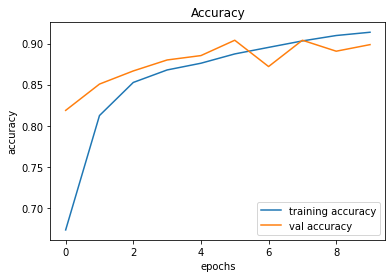

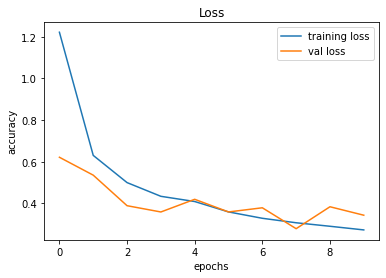

In [ ]:
plot_history(history)

# Testiranje modela

## Testiranje na test skupu

In [ ]:
test_classes_one_hot = to_categorical(test_classes, class_num)
print(test_classes_one_hot)
print(test_classes_one_hot.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
(375, 75)


In [ ]:
predictions = model.predict(test_data, batch_size=1, verbose=1)
rounded_predictions = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_classes, rounded_predictions)

375/375 [==============================] - 29s 71ms/step


In [ ]:
def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=None, normalize=True):

  plt.ion()

  accuracy = np.trace(cm) / np.sum(cm).astype('float')

  if cmap is None:
    cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(34, 26))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.grid(visible=False)
  plt.title(title)
  plt.colorbar()

  if labels is not None:
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
      text = f"{cm[i, j] :0.4f}"
    else:
      text = f"{cm[i, j] :,}"
    
    plt.text(j, i, text, 
             horizontalalignment="center", 
             verticalalignment="center", 
             color="red")


  plt.tight_layout()
  plt.ylabel('True labels')
  plt.xlabel(f'Predicted labels\naccuracy={accuracy :0.4f}')
  plt.show()

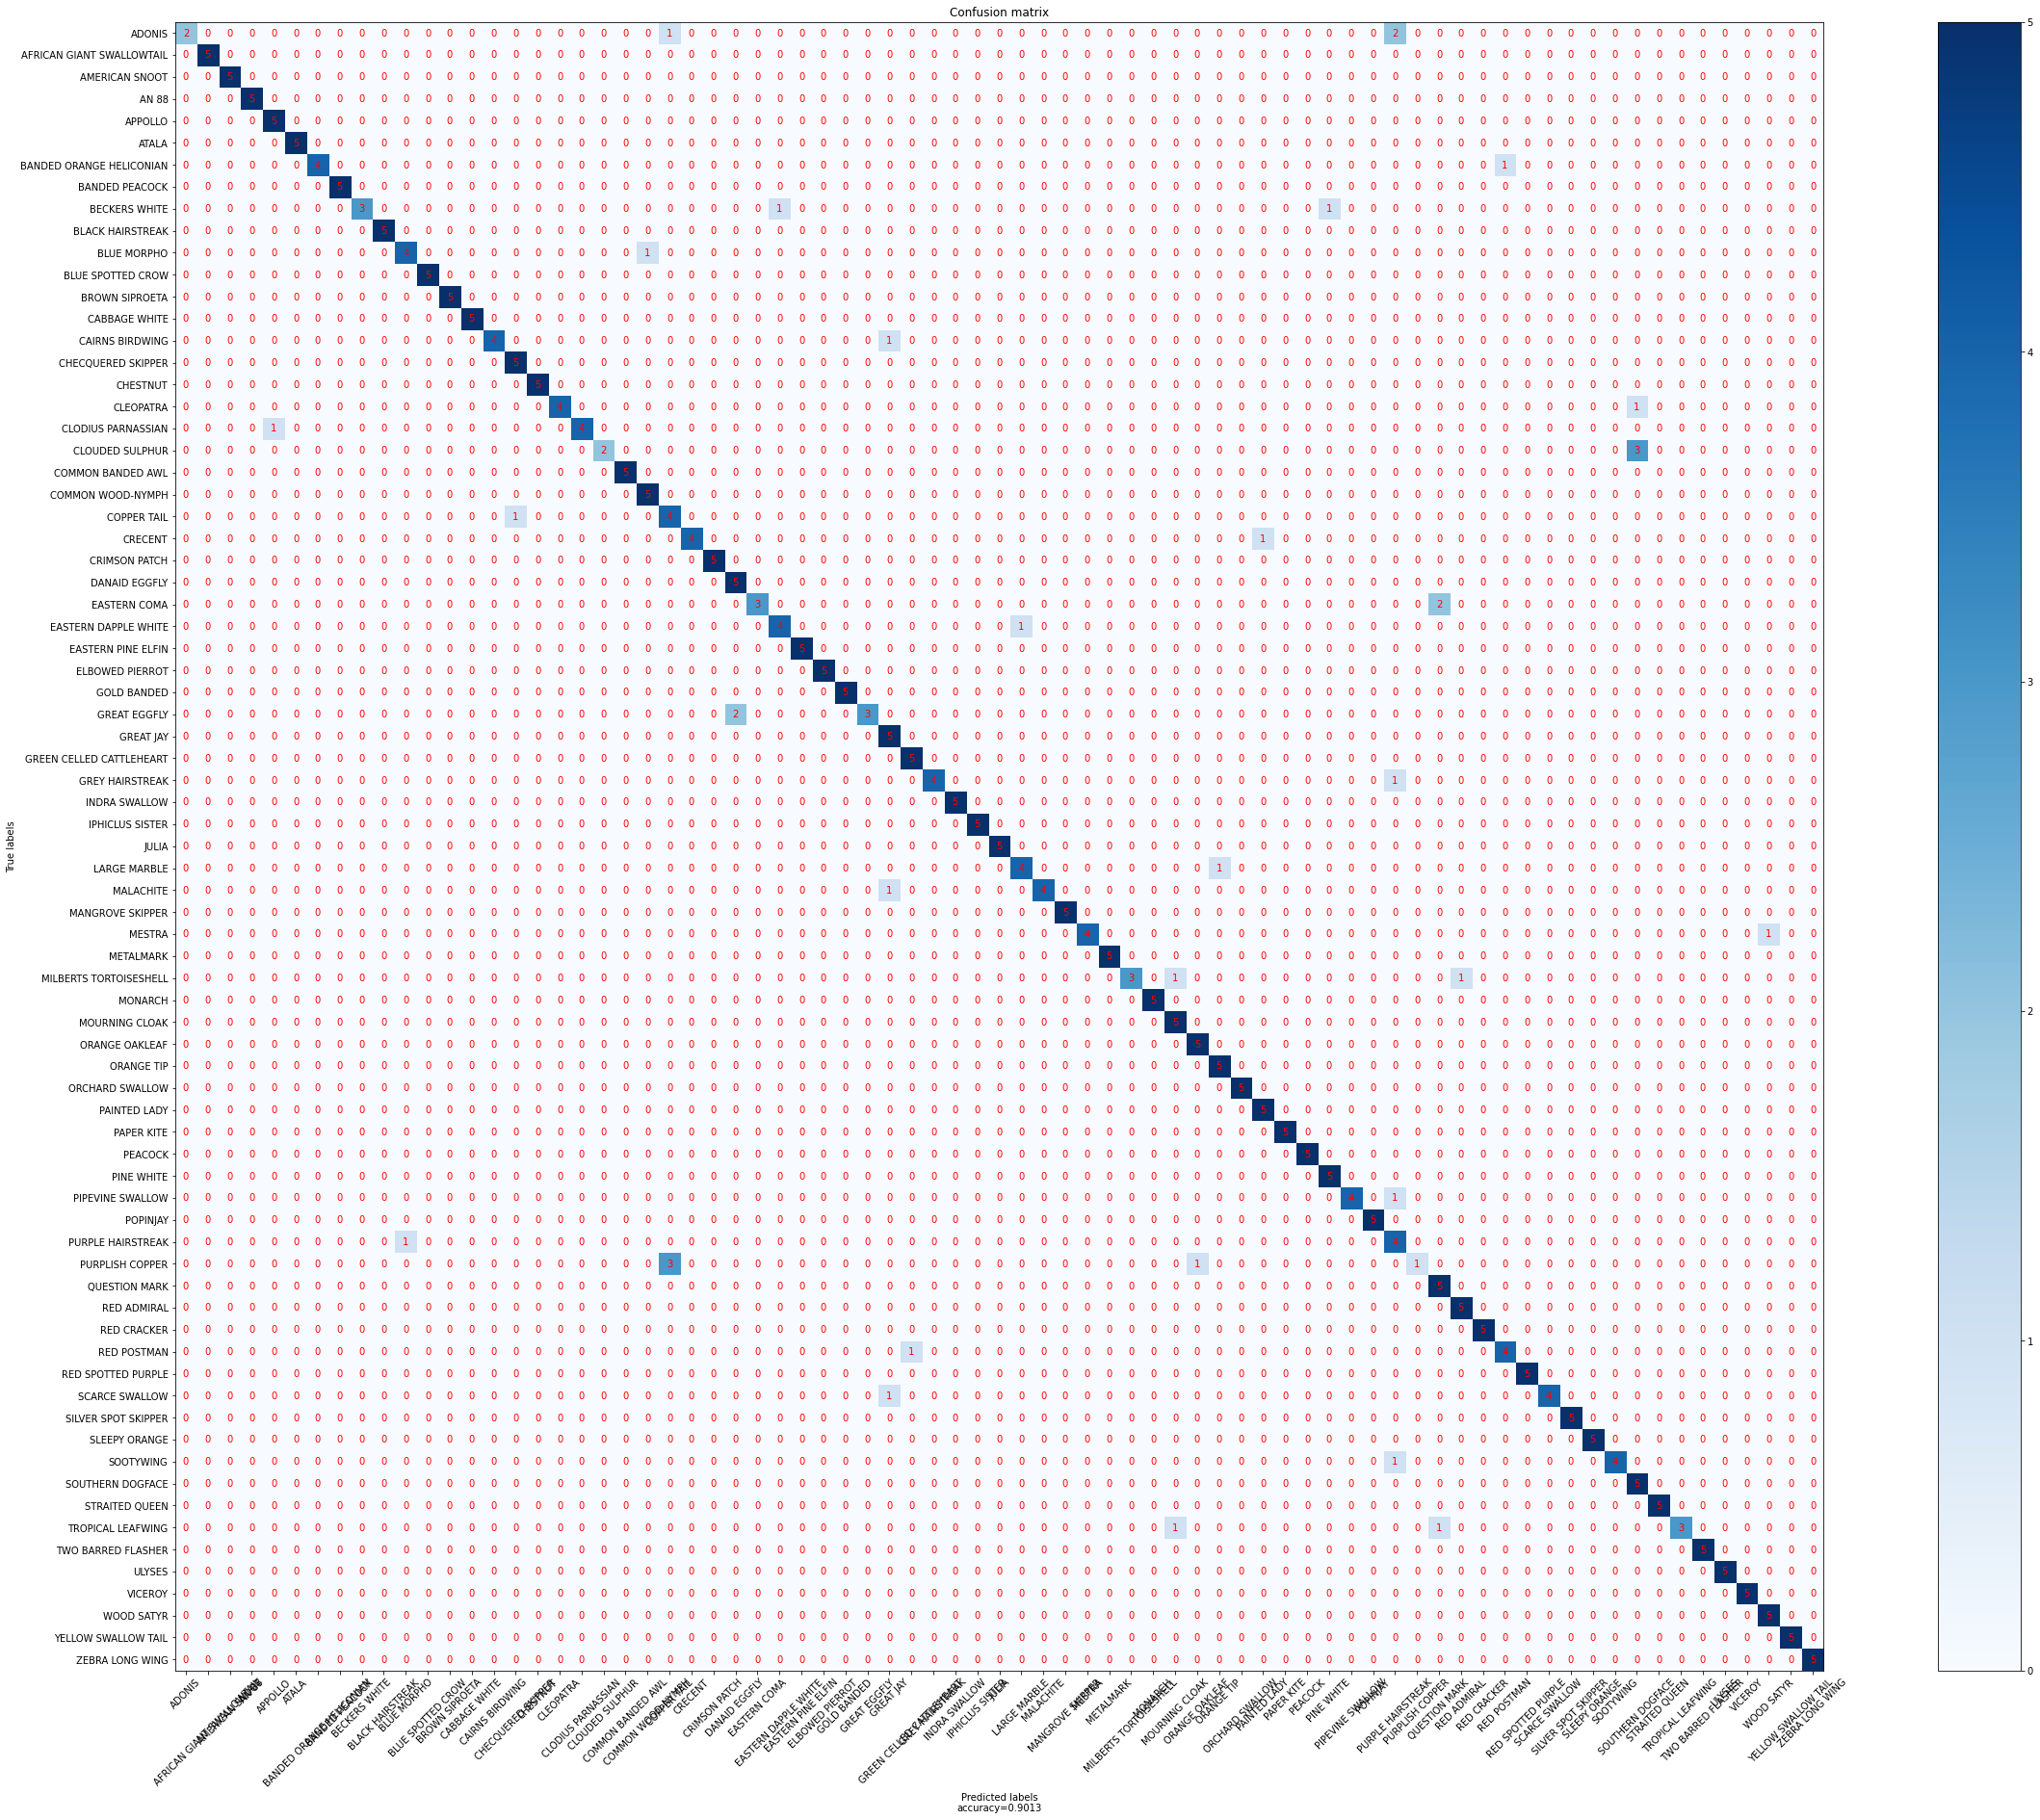

In [ ]:
plot_confusion_matrix(cm, classes, normalize=False)

## Testiranje na individualnim primerima
Na osnovu labela u predikcijama nacicemo primerka te grupe i videti da li je to taj leptir.

In [ ]:
ind_data = []

path = os.path.join('/content/butterfly/6_images')
pics = os.listdir(path)

for p in pics:
  try:
    # print("here")
    image = Image.open(path + '/' + p)
    # print("image done")
    image = image.resize((224, 224))
    image = np.array(image)
    # print("image done")
    ind_data.append(image)
    # print("here")
  except:
    print("Error loading image")

ind_data = np.array(ind_data)

In [ ]:
def plot_images_and_labels(images, predicted_labels):
    plt.figure(figsize=(40, 8))
    n = len(predicted_labels)
    for i in range(n):
      ax = plt.subplot(2, n, i + 1)
      plt.title("original")
      plt.imshow(tf.squeeze(images[i]))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      bx = plt.subplot(2, n, i + n + 1)
      plt.title(predicted_labels[i])
      predicted_image = test_data[test_labels.index(predicted_labels[i])]
      plt.imshow(tf.squeeze(predicted_image))
      bx.get_xaxis().set_visible(False)
      bx.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
predict_data = np.array(random.sample(list(valid_data), 10))

10/10 [==============================] - 1s 74ms/step


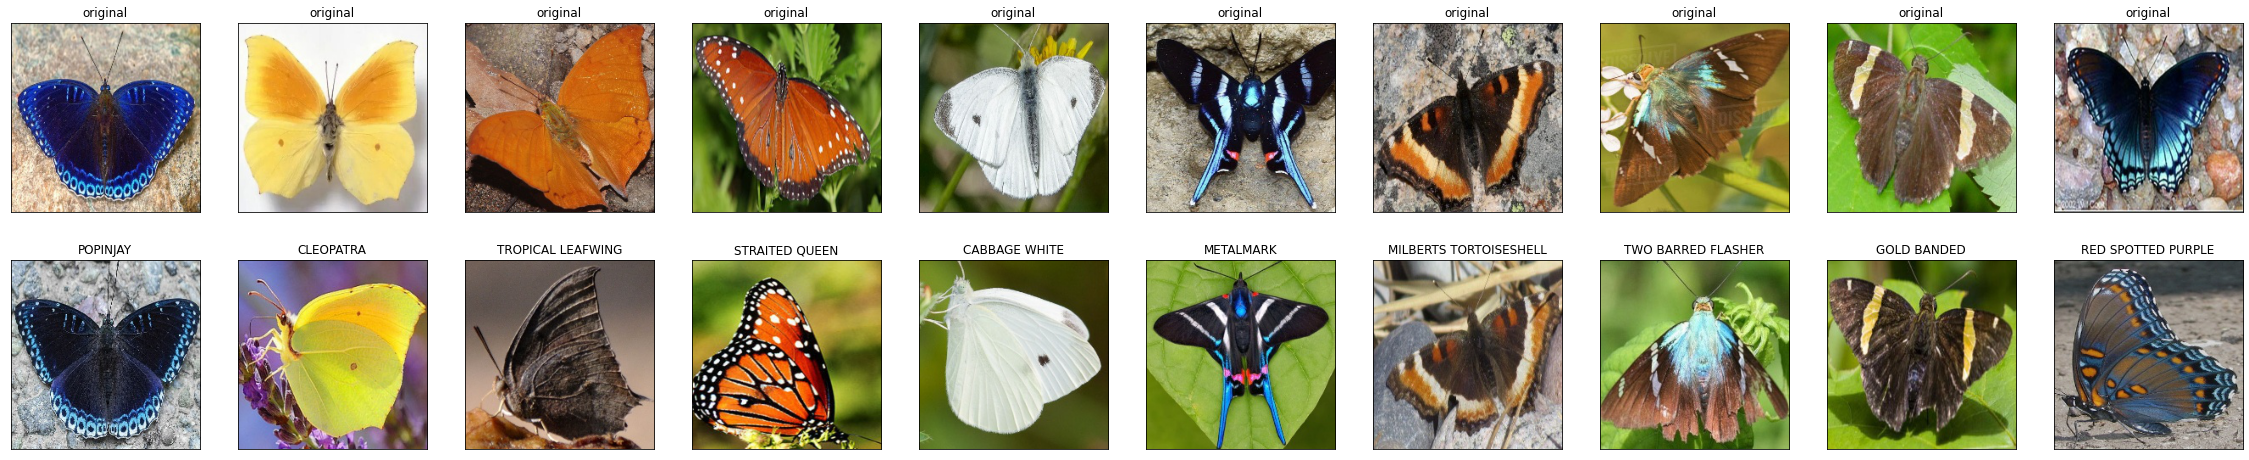

In [ ]:
predictions = model.predict(predict_data, batch_size=1, verbose=1)
rounded_predictions = np.argmax(predictions, axis=1)
predicted_labels = [classes[i] for i in rounded_predictions]
plot_images_and_labels(predict_data, predicted_labels)